In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


**Функции загрузки данных**

In [4]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('/content/drive/MyDrive/Colab Notebooks/d_c_data/train_sample/*.jpg')
test_files = glob('/content/drive/MyDrive/Colab Notebooks/d_c_data/test_sample/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

**Визуализируем примеры для обучения**

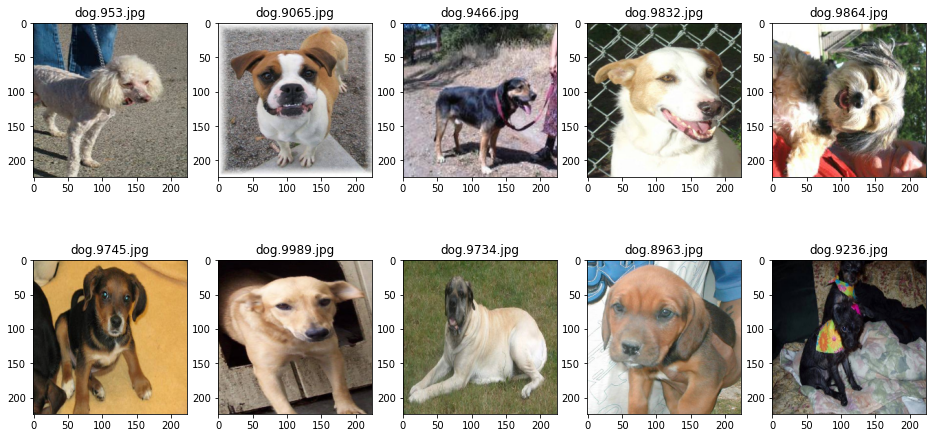

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

**Загружаем предобученную модель**

In [6]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58892288/58889256 [==============================] - 0s 0us/step


In [10]:
# Архитерктура модели
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Добавляем полносвязный слой**

In [7]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [ ]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

**Компилируем модель и запускаем обучение**

1 запуск

In [10]:
model.compile(optimizer='nadam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [11]:
val_samples = 10  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=5,  # число вызовов генератора за эпоху
          epochs=3,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/4
5/5 [==============================] - 93s 19s/step - loss: 3.5451 - accuracy: 0.7714 - val_loss: 0.1283 - val_accuracy: 0.9000
Epoch 2/4
5/5 [==============================] - 89s 18s/step - loss: 0.0807 - accuracy: 0.9850 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 3/4
5/5 [==============================] - 88s 18s/step - loss: 0.1347 - accuracy: 0.9551 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 4/4
5/5 [==============================] - 91s 19s/step - loss: 0.1872 - accuracy: 0.9782 - val_loss: 0.0086 - val_accuracy: 1.0000


2 запуск

In [ ]:
model.compile(optimizer='ftrl', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
val_samples = 10  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=5,  # число вызовов генератора за эпоху
          epochs=4,  # число эпох обучения
          validation_data=validation_data)

ADAM 85s 17s/step - loss: 0.4468 - accuracy: 0.9843 - val_loss: 0.8536 - val_accuracy: 0.9000

SGD 85s 17s/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 1.0000

RMSprop 78s 16s/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 1.2282 - val_accuracy: 0.9000

Adadelta 17s/step - loss: 2.9133 - accuracy: 0.7594 - val_loss: 0.2699 - val_accuracy: 0.9000

Adagrad 83s 17s/step - loss: 0.0265 - accuracy: 0.9923 - val_loss: 2.5443 - val_accuracy: 0.7000

Adamax 75s 15s/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 4.6639 - val_accuracy: 0.8000

Nadam 98s 21s/step - loss: 0.2600 - accuracy: 0.9773 - val_loss: 0.0193 - val_accuracy: 1.0000

Ftrl 45s 9s/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 1.0000

Ftrl + Nadam 85s 17s/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000

 Nadam + Ftrl 87s 18s/step - loss: 0.0932 - accuracy: 0.9820 - val_loss: 0.0139 - val_accuracy: 1.0000


In [10]:
model.save('/content/drive/MyDrive/Colab Notebooks/d_c_data/cats-dogs-vgg16.hdf5')

**Предсказания на проверочной выборке**

In [12]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

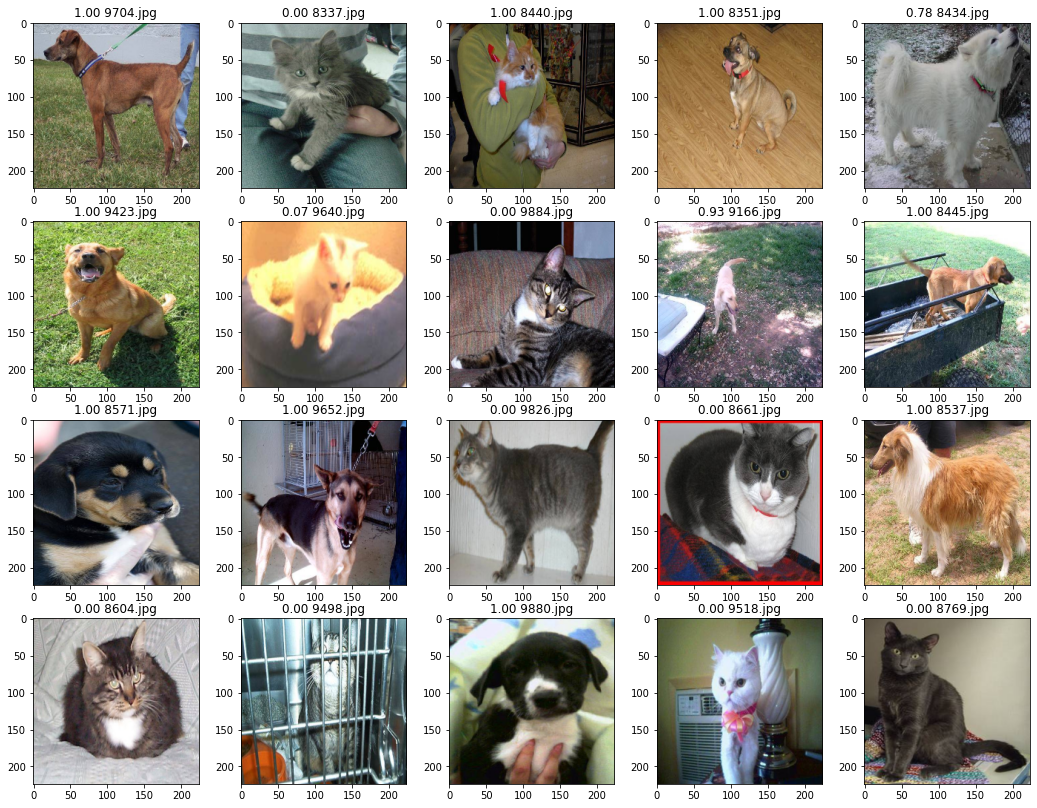

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18, 14))
for i, (path, score) in enumerate(zip(test_files[80:100], test_pred[80:100]), 1):
    subplot = fig.add_subplot(4, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

**Готовим данные для отправки**

In [13]:
import re

with open('/content/drive/MyDrive/Colab Notebooks/submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))